In [ ]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
import re
import spacy
import nltk
from nltk.corpus import stopwords

# Data Collection

## NETFLIX Tweets

In [ ]:
tweet_original_df = pd.read_csv('/content/Ntweets.csv', encoding='iso-8859-1')
tweet_original_df.head()

,ï»¿date,renderedContent
0,2022-07-11 23:55:36+00:00,Important since $nflx may start cracking down ...
1,2022-07-11 23:51:23+00:00,@QTRResearch $GOOGL technicals look good (brok...
2,2022-07-11 23:40:57+00:00,@MikeInTheClutch @joecarlsonshow Exactly. Ther...
3,2022-07-11 23:39:54+00:00,And that's how You negotiate an exclusivity de...
4,2022-07-11 23:33:04+00:00,Trending Stocks on #fintwit: \n\nSource: finap...


In [ ]:
tweet_original_df.rename(columns={'ï»¿date':'date'},inplace=True)

In [ ]:
date_range=tweet_original_df['date'].unique().min(),tweet_original_df['date'].unique().max()
print(date_range)
print('num of rows', len(tweet_original_df))

('2020-01-01 00:03:24+00:00', '2022-07-11 23:55:36+00:00')
num of rows 379331


In [ ]:
tweet_weekend_df=tweet_original_df.copy()
tweet_weekend_df.rename(columns={'renderedContent':'content'},inplace=True)
tweet_weekend_df.rename(columns={'date':'datetime'},inplace=True)

In [ ]:
tweet_weekend_df.head()

,datetime,content
0,2022-07-11 23:55:36+00:00,Important since $nflx may start cracking down ...
1,2022-07-11 23:51:23+00:00,@QTRResearch $GOOGL technicals look good (brok...
2,2022-07-11 23:40:57+00:00,@MikeInTheClutch @joecarlsonshow Exactly. Ther...
3,2022-07-11 23:39:54+00:00,And that's how You negotiate an exclusivity de...
4,2022-07-11 23:33:04+00:00,Trending Stocks on #fintwit: \n\nSource: finap...


In [ ]:
tweet_weekend_df['date'] = pd.to_datetime(tweet_weekend_df['datetime']).dt.date
tweet_weekend_df['datetime'] = pd.to_datetime(tweet_weekend_df['datetime'])
tweet_weekend_df.head()

,datetime,content,date
0,2022-07-11 23:55:36+00:00,Important since $nflx may start cracking down ...,2022-07-11
1,2022-07-11 23:51:23+00:00,@QTRResearch $GOOGL technicals look good (brok...,2022-07-11
2,2022-07-11 23:40:57+00:00,@MikeInTheClutch @joecarlsonshow Exactly. Ther...,2022-07-11
3,2022-07-11 23:39:54+00:00,And that's how You negotiate an exclusivity de...,2022-07-11
4,2022-07-11 23:33:04+00:00,Trending Stocks on #fintwit: \n\nSource: finap...,2022-07-11


In [ ]:
date_range=tweet_weekend_df['datetime'].unique().min(),tweet_weekend_df['datetime'].unique().max()
print(date_range)
print('num of rows', len(tweet_weekend_df))

(Timestamp('2020-01-01 00:03:24+0000', tz='UTC'), Timestamp('2022-07-11 23:55:36+0000', tz='UTC'))
num of rows 379331


In [ ]:
tweet_vol_df=tweet_weekend_df.groupby('date').count()['content'].reset_index()
tweet_vol_df.head()

,date,content
0,2020-01-01,123
1,2020-01-02,339
2,2020-01-03,309
3,2020-01-04,106
4,2020-01-05,127


## NETFLIX stock price
- Original stock price parquet
- Processed Stock Price parquet (DONE)

In [ ]:
import time
stock = ['NFLX']
start = dt.datetime(2020,1,1)
end = dt.datetime(2022,7,11)
stock_df = yf.download(stock, start, end)
time.sleep(5)
stock_df

In [ ]:
stock_df.columns = stock_df.columns.droplevel(1)  #flatten/remove NFLX layer
stock_df.columns.name = None #delete the leftover name
stock_df = (
    stock_df
    .reset_index() #Date index to column called “index”
    .rename(columns={'index': 'Date'})
    [['Date', 'Close', 'High', 'Low', 'Open', 'Volume']]
    )
stock_df

In [ ]:
stock_df.rename(columns={'Date':'date',
                         'Close': 'close',
                         'High':'high',
                         'Low':'low',
                         'Open': 'open',
                         'Volume':'volume'},inplace=True)

In [ ]:
# TO DEAL WITH EXCEEDING RATE LIMIT OF DOWNLOADING STOCK PRICE USING YFINANCE.SAVE PROCESSED DATASET IN PARQUET
stock_df = pd.read_parquet('./stock_prices.parquet')
stock_df.head()


,date,close,high,low,open,volume,PrevReturn,next_open,next_close,label_open_up,label_close_up,earnings_window
0,2020-01-02,329.809998,329.980011,324.779999,326.100006,4485800,0.000000,326.779999,325.899994,0,0,0
1,2020-01-03,325.899994,329.859985,325.529999,326.779999,3806900,-0.011855,323.119995,335.829987,0,1,0
2,2020-01-06,335.829987,336.359985,321.200012,323.119995,5663100,0.030469,336.470001,330.750000,1,0,0
3,2020-01-07,330.750000,336.700012,330.299988,336.470001,4703200,-0.015127,331.489990,339.260010,1,1,0
4,2020-01-08,339.260010,342.700012,331.049988,331.489990,7104500,0.025729,342.000000,335.660004,1,0,0


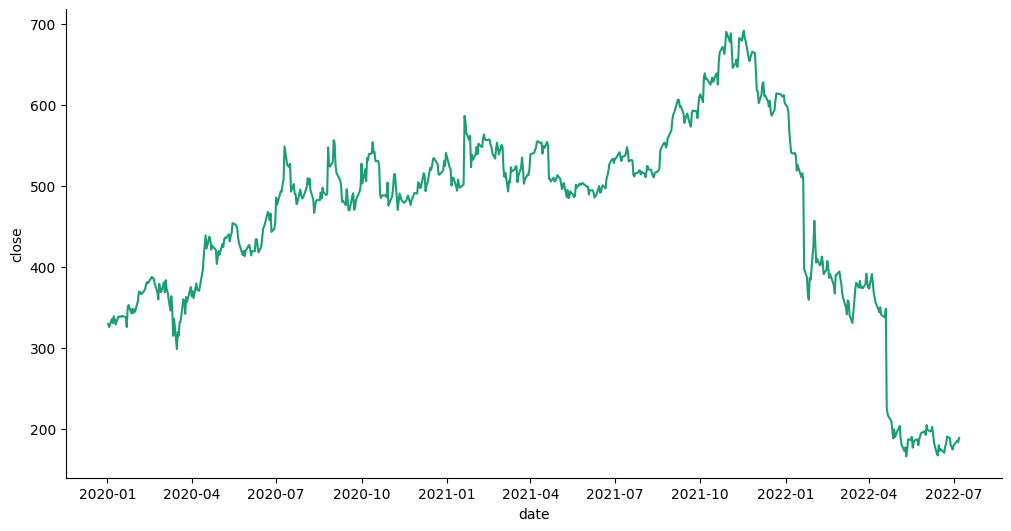

In [ ]:
# @title date vs close
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = stock_df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('close')

#Text Preprocessing

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_tweet(text):
  #Replace cashtags with [TICKER] token as remove cashtags
  text = re.sub(r'\$[A-Za-z]+', '[TICKER]', text)
  #Remove URLs
  text = re.sub(r'http\S+|www.\S+', '', text)
  #Remove mentions,hashtags
  text = re.sub(r'@\w+|\#\w+|\$\w+', '', text)
  #Remove emojis, sacrify punctuation
  text = re.sub(r'[^\x00-\x7F]+', '', text)
  #Tokenization and lower-casing
  tokens = nltk.word_tokenize(text.lower())
  return ' '.join(tokens)

there are float values present in the 'content' column of tweet_weekend_df
=> Change them to strings

In [ ]:
tweet_weekend_df['content'] = tweet_weekend_df['content'].astype(str)
tweet_weekend_df['cleaned_text'] = tweet_weekend_df['content'].apply(preprocess_tweet)
tweet_weekend_df

,datetime,content,date,cleaned_text
0,2022-07-11 23:55:36+00:00,Important since $nflx may start cracking down ...,2022-07-11,important since [ ticker ] may start cracking ...
1,2022-07-11 23:51:23+00:00,@QTRResearch $GOOGL technicals look good (brok...,2022-07-11,[ ticker ] technicals look good ( broke above ...
2,2022-07-11 23:40:57+00:00,@MikeInTheClutch @joecarlsonshow Exactly. Ther...,2022-07-11,exactly . there may never be a way to weigh [ ...
3,2022-07-11 23:39:54+00:00,And that's how You negotiate an exclusivity de...,2022-07-11,and that 's how you negotiate an exclusivity d...
4,2022-07-11 23:33:04+00:00,Trending Stocks on #fintwit: \n\nSource: finap...,2022-07-11,trending stocks on : source : finapse.live 1 ....
...,...,...,...,...
379326,2020-01-01 00:38:49+00:00,$nflx December ended w candle rested on 20ema....,2020-01-01,[ ticker ] december ended w candle rested on 2...
379327,2020-01-01 00:36:21+00:00,Guess what! I noticed today #TheBourneIdentity...,2020-01-01,guess what ! i noticed today is on [ ticker ]
379328,2020-01-01 00:22:51+00:00,What happened today in the #StockMarket? \n\nP...,2020-01-01,what happened today in the ? performance of se...
379329,2020-01-01 00:20:37+00:00,This is one that we traded over at @TAtradesPr...,2020-01-01,this is one that we traded over at - inverted ...


# EDA

## Sat/Sun tweets -> Next Monday

In [ ]:
#Push Sat/Sun tweets to next Monday
tweet_no_weekend_df = tweet_weekend_df.copy()
tweet_no_weekend_df['date'] = pd.to_datetime(tweet_no_weekend_df['date'])
#tweet_no_weekend_df['date'] = tweet_no_weekend_df['date'].dt.normalize()
wday = tweet_no_weekend_df['date'].dt.weekday
tweet_no_weekend_df.loc[wday == 5, 'date'] += pd.Timedelta(days=2)  #Sat to mon
tweet_no_weekend_df.loc[wday == 6, 'date'] += pd.Timedelta(days=1)  #sun to mon

In [ ]:
#Aggregate tweet vol df
tweet_vol_df = (
    tweet_no_weekend_df.groupby('date')['cleaned_text']
      .count()
      .rename('tweetVol')
      .reset_index()
)
tweet_no_weekend_df
tweet_vol_df


,date,tweetVol
0,2020-01-01,123
1,2020-01-02,339
2,2020-01-03,309
3,2020-01-06,776
4,2020-01-07,422
...,...,...
654,2022-07-05,425
655,2022-07-06,538
656,2022-07-07,433
657,2022-07-08,279


## Plotting: Merge tweet and stock df

In [ ]:
stock_df['date'] = pd.to_datetime(stock_df['date'])
tweet_vol_df['date'] = pd.to_datetime(tweet_vol_df['date'])

In [ ]:
plot_merged_df=tweet_vol_df.merge(stock_df,on='date',how='left')
plot_merged_df

,date,tweetVol,close,high,low,open,volume,PrevReturn,next_open,next_close,label_open_up,label_close_up,earnings_window
0,2020-01-01,123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02,339,329.809998,329.980011,324.779999,326.100006,4485800.0,0.000000,326.779999,325.899994,0.0,0.0,0.0
2,2020-01-03,309,325.899994,329.859985,325.529999,326.779999,3806900.0,-0.011855,323.119995,335.829987,0.0,1.0,0.0
3,2020-01-06,776,335.829987,336.359985,321.200012,323.119995,5663100.0,0.030469,336.470001,330.750000,1.0,0.0,0.0
4,2020-01-07,422,330.750000,336.700012,330.299988,336.470001,4703200.0,-0.015127,331.489990,339.260010,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,2022-07-05,425,185.880005,185.919998,172.679993,176.279999,7334300.0,0.032954,185.199997,184.059998,0.0,0.0,0.0
655,2022-07-06,538,184.059998,186.220001,180.820007,185.199997,5753400.0,-0.009791,184.270004,189.270004,1.0,1.0,0.0
656,2022-07-07,433,189.270004,190.210007,183.500000,184.270004,6334500.0,0.028306,186.020004,186.979996,0.0,0.0,0.0
657,2022-07-08,279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


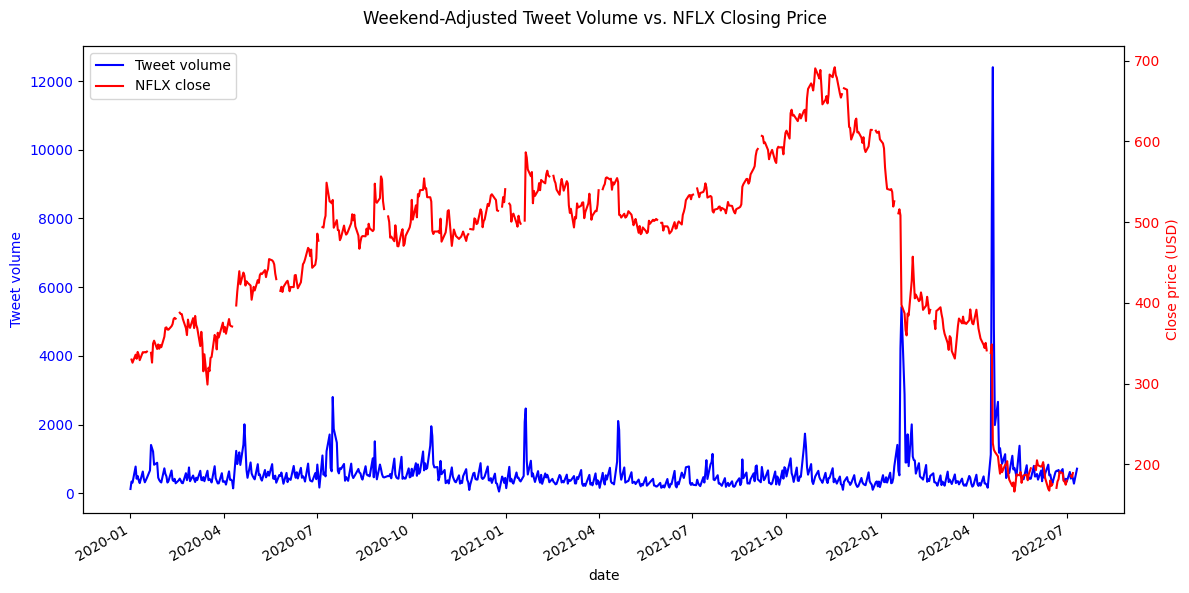

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(plot_merged_df['date'], plot_merged_df['tweetVol'],color='blue', label='Tweet volume')
ax1.set_xlabel('date')
ax1.set_ylabel('Tweet volume', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2.plot(plot_merged_df['date'], plot_merged_df['close'], color='red', label='NFLX close')
ax2.set_ylabel('Close price (USD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Weekend-Adjusted Tweet Volume vs. NFLX Closing Price')
fig.autofmt_xdate()

#combined legend
lns = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper left')
plt.grid(True, which='both', axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

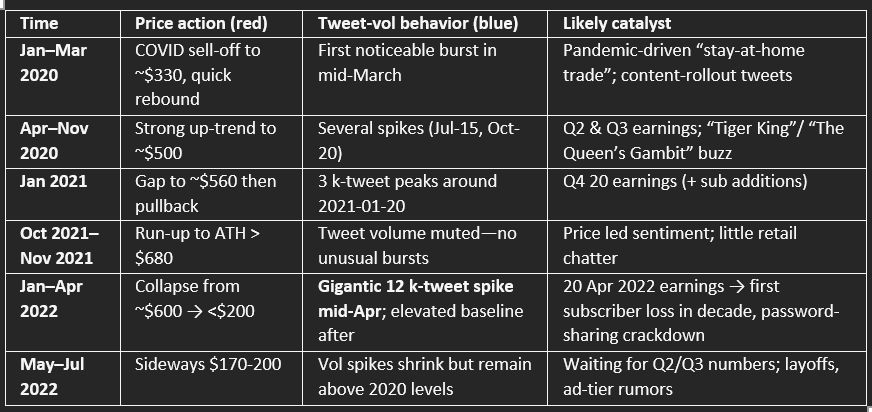

###Take-aways for modelling
**Volume spikes cluster around earnings or shock news** – incorporate an earnings-week dummy or lagged tweet-volume features.

**Biggest bursts accompany negative gaps (Apr 2022):** - raw volume alone may point to downside risk; consider adding a “sentiment × volume” interaction.

**Long bullish stretches (mid-2021) had few tweets** – sentiment signal may be weaker during gradual rallies; model might overweight dramatic events unless balancing by time-decay or rolling z-scores.

**Structural break post-Apr 2022** – higher baseline chatter even with lower price. Train/val/test split should put 2022+ in validation or test to check robustness.

# Feature Engineering

## Target Cols Construction

In [ ]:
# stock_df['PrevReturn'] = stock_df['close'].pct_change().fillna(0)
# stock_df['next_open']  = stock_df['open'].shift(-1)
# stock_df['next_close'] = stock_df['close'].shift(-1)
# stock_df['label_open_up']  = (stock_df['next_open']  > stock_df['close']).astype(int)
# stock_df['label_close_up'] = (stock_df['next_close'] > stock_df['close']).astype(int)
# #Drop final row with NaN
# stock_df = stock_df.dropna(subset=['next_open','next_close'])

In [ ]:
# stock_df

Compare next open with current close:
- Designing a strategy that buys (or sells) at the market close and exits at next day’s open.
- Studying how information released after 4 p.m. (earnings calls, late news, tweets) is absorbed by the next open.
- “Over-night gap” – how much the market jumps between the close of day t and the opening print of day t + 1.

=> using tweets that arrive continuously—including after-hours chatter—and want to see whether sentiment “carries” into the next session. This frames the problem as: “Given all tweets up to the end of day t, will tomorrow open/close beat today’s closing benchmark?” It cleanly ties the model’s information set (tweets up to 16:00) to an actionable trade you could enter at the close

## Earnings-week dummy or lagged tweet-volume features
- A binary column (earnings_window) that tells the model whether a row is within one trading day before, on, or after Netflix’s quarterly earnings-release date.
0 → “ordinary” day  
1 → “earnings-window” day (d = E−1, E, E+1)

In [ ]:
# earn_dates = pd.to_datetime([
#     "2020-01-21","2020-04-21","2020-07-16","2020-10-20",
#     "2021-01-19","2021-04-20","2021-07-20","2021-10-19",
#     "2022-01-20","2022-04-19","2022-07-19","2022-10-18",
#     "2023-01-19","2023-04-20","2023-07-19","2023-10-18",
#     "2024-01-23"
# ])
# stock_df['earnings_window'] = 0
# for d in earn_dates:
#     mask = stock_df['date'].between(d - pd.Timedelta(days=1),
#                                      d + pd.Timedelta(days=1))
#     stock_df.loc[mask, 'earnings_window'] = 1

In [ ]:
# print(stock_df[stock_df['earnings_window'] == 1])

## Sentiment Preprocessing

### sentence-transformers/all-mpnet-base-v2

In [ ]:
import torch
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader
from tqdm import tqdm

tweets_df = tweet_no_weekend_df.copy()
texts     = tweets_df['cleaned_text'].tolist()

# Device, model setu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = SentenceTransformer(
    'sentence-transformers/all-mpnet-base-v2',
    device=device
)
model.eval()
if device.type == 'cuda':
    #weights&activations FP16 for speed
    model.half()
    #cuDNN autotune the best algorithms
    torch.backends.cudnn.benchmark = True
#Dataloader
batch_size = 2048
loader = DataLoader(
    texts,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4, #adjust to your CPU cores
    pin_memory=True#faster host->GPU copies
)
#Embedding Loop
all_embs = []
with torch.no_grad():
    for batch in tqdm(loader, desc="On-device embedding"):
        # encode returns a CUDA tensor in FP16
        embs = model.encode(
            batch,
            convert_to_tensor=True,
            show_progress_bar=False
        )
        #move to CPU+cast back to FP32 before storing
        all_embs.append(embs.cpu().float())

#Concatenate &attach to df
all_embs = torch.cat(all_embs, dim=0).numpy().tolist()
tweets_df['emb_mpnet_basev2'] = all_embs



Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

On-device embedding: 100%|██████████| 186/186 [06:35<00:00,  2.13s/it]


In [ ]:
tweets_df.head()

,datetime,content,date,cleaned_text,emb_mpnet_basev2
0,2022-07-11 23:55:36+00:00,Important since $nflx may start cracking down ...,2022-07-11,important since [ ticker ] may start cracking ...,"[-0.035491943359375, -0.0006866455078125, -0.0..."
1,2022-07-11 23:51:23+00:00,@QTRResearch $GOOGL technicals look good (brok...,2022-07-11,[ ticker ] technicals look good ( broke above ...,"[-0.013519287109375, 0.007720947265625, -0.020..."
2,2022-07-11 23:40:57+00:00,@MikeInTheClutch @joecarlsonshow Exactly. Ther...,2022-07-11,exactly . there may never be a way to weigh [ ...,"[-0.048553466796875, 0.032440185546875, 0.0014..."
3,2022-07-11 23:39:54+00:00,And that's how You negotiate an exclusivity de...,2022-07-11,and that 's how you negotiate an exclusivity d...,"[-0.01168060302734375, 0.01544952392578125, -0..."
4,2022-07-11 23:33:04+00:00,Trending Stocks on #fintwit: \n\nSource: finap...,2022-07-11,trending stocks on : source : finapse.live 1 ....,"[-0.052886962890625, -0.00390625, -0.036987304..."


In [ ]:
# Save processed data to parquet
from pathlib import Path
out_dir = Path("processed")
out_dir.mkdir(exist_ok=True)
tweets_df.to_parquet(out_dir / 'tweets_embedded_df.parquet')

In [ ]:
# stock_df.to_parquet(out_dir / "stock_prices.parquet", index=False)

### (DIFFERENT NOTEBOOK FROM HERE)